In [1]:
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np 
import pandas as pd
from string import ascii_letters
import os
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# PREPROCESSING THE INGREDIENTS

In [20]:
# need to remove these from ingredients
measurements = (['tablespoon', 'tbsp', 'teaspoon', 'tsp', 'cup', 'pint', 'pt', 
                 'quart', 'qt', 'gallon', 'gal', 'ounce', 'ounc', 'ounces', 'oz', 'fluid', 'fl', 'pound', 
                 'lb', 'liter', 'litre', 'l', 'ml', 'gram', 'g', 'inch', 'diameter', 'meter', 'medium',
                 'grill', 'cm', 'handful', 'size', 'firm', 'cupg', 'cupsg', 'cupsml', 'x', 'little', 'divided',
                 'total', 'more', 'package', 'bag', 'bottle', 'tbspg', 'xxinch', 'box', 'instructions', 'info',
                 'ozg', 'lbg', 'kg'])

In [21]:
is_noun = lambda pos: pos[:2] == 'NN'
stemmer = nltk.stem.PorterStemmer()

all_ingredients = []

def parse_ingredients(row):
    list = row['Cleaned_Ingredients'].split(',')
    ingredients = []
    for ingredient in list:
        # removing non-letters
        letter_only = ''.join(l for l in ingredient if l in set(ascii_letters + ' '))
        # tokenizing into words
        tokenized = nltk.word_tokenize(letter_only)
        # remove all except nouns, and remove measurements
        nouns = [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN' or pos[:2] == 'NNS')]
        nouns = [noun for noun in nouns if (noun not in measurements) and (stemmer.stem(noun) not in measurements)]
        if len(tokenized) > 0 and len(nouns) == 0:
            nouns.append(tokenized[-1])
        # add as new row, also add to a full ingredient list as features
        joined = ' '.join(nouns)
        ingredients.append(joined)
        if joined not in all_ingredients:
            all_ingredients.append(joined)
    return ','.join(ingredients)

In [22]:
df = pd.read_csv('data/food.csv')

#
# UNCOMMENT THIS TO PARSE THE ENTIRE CSV
df['parsed_ingredients'] = df.apply(parse_ingredients, axis=1)
#

In [23]:
with open('data/ingredients.txt', 'w') as f:
    for line in all_ingredients:
        f.write(f"{line}\n")

In [24]:
print(df.head())
print(len(all_ingredients))

   Unnamed: 0                                              Title  \
0           0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1           1                    Crispy Salt and Pepper Potatoes   
2           2                        Thanksgiving Mac and Cheese   
3           3                 Italian Sausage and Bread Stuffing   
4           4                                       Newton's Law   

                                         Ingredients  \
0  ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1  ['2 large egg whites', '1 pound new potatoes (...   
2  ['1 cup evaporated milk', '1 cup whole milk', ...   
3  ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4  ['1 teaspoon dark brown sugar', '1 teaspoon ho...   

                                        Instructions  \
0  Pat chicken dry with paper towels, season all ...   
1  Preheat oven to 400°F and line a rimmed baking...   
2  Place a rack in middle of oven; preheat to 400...   
3  Preheat oven to 350°F with 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

In [26]:
ingredient_strings = df['parsed_ingredients']
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','))
vectorized_documents = vectorizer.fit_transform(ingredient_strings)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Reducing Dimensions using PCA

In [ ]:
#
# DON'T RUN
# FINDING THE NUMBER OF COMPONENTS
#

pca = PCA()
pca.fit_transform(vectorized_documents.toarray())

# get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [28]:
pca = PCA(n_components=1750)
reduced_ingredients = pca.fit_transform(vectorized_documents.toarray())

In [36]:
all_ingredients = vectorizer.get_feature_names_out()
ingredient_component_mapping = pd.DataFrame(pca.components_, columns=all_ingredients)
print(ingredient_component_mapping)

['' 'a dark grade b maple syrup' 'a varieties' ... 'zucchinis'
 'zucchinis courgettes' 'zwieback toasts']
                a dark grade b maple syrup  a varieties  abita amber beer  \
0    -0.002030                    0.000122     0.000122         -0.000093   
1    -0.014947                   -0.000321    -0.000321         -0.000216   
2    -0.006804                    0.000007     0.000007         -0.000096   
3     0.004094                    0.000291     0.000291         -0.000080   
4    -0.005857                   -0.000258    -0.000258          0.000271   
...        ...                         ...          ...               ...   
1745  0.000972                    0.000889     0.000889          0.000797   
1746  0.002184                    0.001894     0.001894         -0.002119   
1747 -0.000671                   -0.000119    -0.000119         -0.003133   
1748 -0.000772                   -0.001214    -0.001214          0.003696   
1749 -0.002424                   -0.001676    -

In [37]:
# get the loadings of each principal component
pca_ingredients = []
for i, pc in enumerate(pca.components_):
    index = np.argsort(np.abs(pc))[::-1]
    
    found = False
    i = 0
    while found == False:
        ing = all_ingredients[index[i]]
        if ing in pca_ingredients:
            i += 1
        else:
            pca_ingredients.append(ing)
            found = True

In [22]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torch.utils.data import DataLoader, Dataset

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# load CLIP
model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(model_name)
clip_model = CLIPModel.from_pretrained(model_name)
clip_model.eval()

# get image encodings for our model
def encode_image(image):
    # returns pytorch tensors
    inputs = clip_processor(images=image, return_tensors="pt")

    # encode image, stop gradient calculation and backpropagation
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    return image_features

# Example usage
image_path = 'data/images/images/3-ingredient-blueberry-champagne-granita.jpg'
image_features = encode_image(image_path)
print(image_features.shape)  # Shape of the image features (batch_size, feature_dim)

# The image features will be a tensor of shape (1, 512), where 512 is the dimensionality of the image embeddings.

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([1, 512])


In [46]:
IMAGE_SIZE = (224,224)

def prepare_image (image):
    img = Image.open (image)
    img = img.resize (IMAGE_SIZE)
    img = np.expand_dims(img,axis = 0 ),
    img = img/255.0
    return img

image_dir = 'data/images/images/'
def process_images(row):
    image_path = image_dir + row['Image_Name'] + '.jpg'
            
    # preprocess image
    preprocessed_image = prepare_image(image_path)

    # encode image
    image_features = encode_image(preprocessed_image)
    return image_features

In [47]:
df['image_encoding'] = df.apply(process_images, axis=1)

TypeError: unsupported operand type(s) for /: 'tuple' and 'float'

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, images, ingredients, clip_processor):
        self.images = images
        self.ingredients = ingredients
        self.clip_processor = clip_processor
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        ingredient = self.ingredients[idx]
        image_inputs = self.clip_processor(text=image, return_tensors="pt", padding=True)
        ingredient_inputs = ... # Process ingredient text (e.g., tokenization)
        return image_inputs, ingredient_inputs

# Prepare data loaders for training
train_dataset = FoodDataset(images=train_images, ingredients=train_ingredients, clip_processor=clip_processor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define model architecture
class IngredientPredictionModel(torch.nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.fc = torch.nn.Linear(512, num_ingredients)  # Adjust output size based on the number of ingredients
    
    def forward(self, images, ingredients):
        image_features = self.clip.get_image_features(**images)
        ingredient_features = ...  # Process ingredient inputs (e.g., embedding)
        features = torch.cat([image_features, ingredient_features], dim=1)
        logits = self.fc(features)
        return logits

# Instantiate model
model = IngredientPredictionModel(clip_model)

# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, ingredients in train_loader:
        optimizer.zero_grad()
        logits = model(images, ingredients)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

# K-MEANS (probably don't need this)

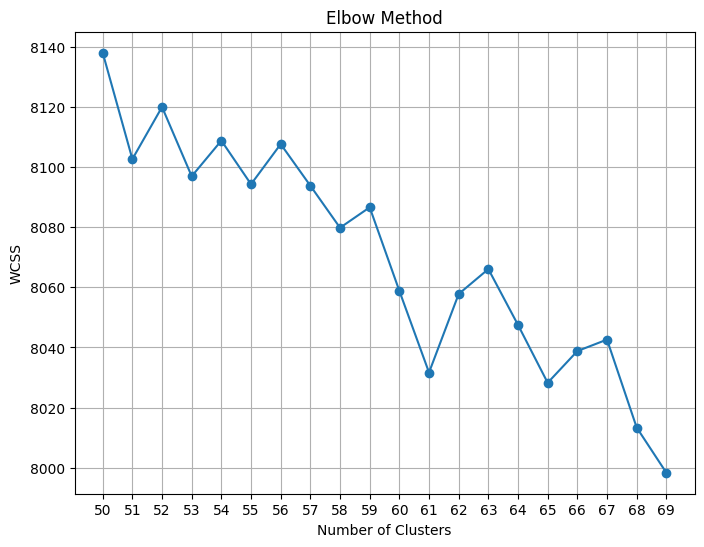

In [31]:
#
# calculate WCSS for different values of k
# DON'T RUN
#
wcss = []
low_range = 1
high_range = 70
for i in range(low_range, high_range):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10, random_state=0)
    kmeans.fit(reduced_ingredients)
    wcss.append(kmeans.inertia_)

# plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(low_range, high_range), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(low_range, high_range, 1))
plt.grid(True)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=61, max_iter=300) 
kmeans.fit(reduced_ingredients) 

KMeans(n_clusters=61)